# Test Neural SDEs

`torchdyn` NeuralSDE implementation relies on XuChen Li's `torchsde` implementation of several SDE solvers and sensitivity analysis tools.

In this tutorial we briefly introduce NeuralSDEs in `torchdyn`, with basic implementation of both *Ito* and *Stratonivich* -type SDEs

TO DO:
* test noise types

In [1]:
import sys ; sys.path.append('../../')
from torchdyn.models import *
from torchdyn.datasets import *
from torchdyn import *

In [2]:
import torch 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torch.distributions import Uniform
prior = Uniform(-torch.ones(2).to(device), torch.ones(2).to(device))

## Stratonovich SDEs

In [3]:
f = nn.Sequential(nn.Linear(2, 64), nn.Tanh(), nn.Linear(64, 2))
g = nn.Sequential(nn.Linear(2, 64), nn.Tanh(), nn.Linear(64, 2))

nsde = NeuralSDE(f, g,
                noise_type='diagonal',
                sde_type='stratonovich',
                sensitivity='adjoint',
                s_span=torch.linspace(0, 1, 100),
                solver='euler',
                atol=0.0001,
                rtol=0.0001).to(device)

In [4]:
# test backward adjoint
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
print(x0.grad.shape)

# test backward autograd
nsde.sensitivity = 'autograd'
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
print(x0.grad.shape)


torch.Size([100, 2])
torch.Size([100, 2])


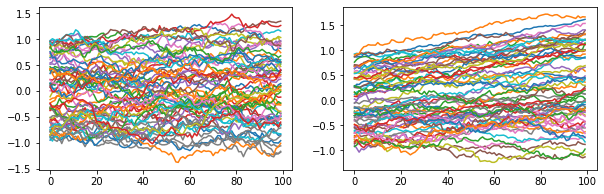

In [5]:
# test_trajectory
bs = 64 ; s_span = torch.linspace(0, 1, 100)
x0 = prior.sample(torch.Size([bs]))
traj = nsde.trajectory(x0, s_span).detach().cpu()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i in range(bs):
    ax[0].plot(traj[:,i,0])
    ax[1].plot(traj[:,i,1])

## Ito SDEs

In [6]:
f = nn.Sequential(nn.Linear(2, 64), nn.Tanh(), nn.Linear(64, 2))
g = nn.Sequential(nn.Linear(2, 64), nn.Tanh(), nn.Linear(64, 2))

nsde = NeuralSDE(f, g,
                noise_type='diagonal',
                sde_type='ito',
                sensitivity='adjoint',
                s_span=torch.linspace(0, 1, 100),
                solver='euler',
                atol=0.0001,
                rtol=0.0001).to(device)

In [7]:
# test backward adjoint
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
print(x0.grad.shape)

# test backward autograd
nsde.sensitivity = 'autograd'
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
print(x0.grad.shape)


torch.Size([100, 2])
torch.Size([100, 2])


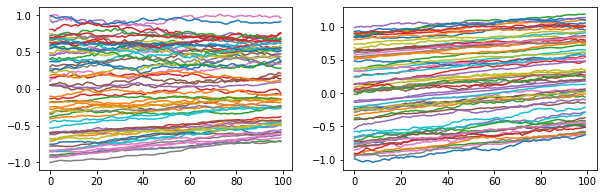

In [8]:
# test_trajectory
bs = 64 ; s_span = torch.linspace(0, 1, 100)
x0 = prior.sample(torch.Size([bs]))
traj = nsde.trajectory(x0, s_span).detach().cpu()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i in range(bs):
    ax[0].plot(traj[:,i,0])
    ax[1].plot(traj[:,i,1])

## DepthCat in Drift and Diffusion

In [9]:
f = nn.Sequential(DepthCat(1), nn.Linear(3, 64), nn.Tanh(), nn.Linear(64, 2))
g = nn.Sequential(DepthCat(1), nn.Linear(3, 64), nn.Tanh(), nn.Linear(64, 2))

nsde = NeuralSDE(f, g,
                noise_type='diagonal',
                sde_type='ito',
                sensitivity='adjoint',
                s_span=torch.linspace(0, 1, 100),
                solver='euler',
                atol=0.0001,
                rtol=0.0001).to(device)

In [10]:
# test backward adjoint
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
print(x0.grad.shape)

# test backward autograd
nsde.sensitivity = 'autograd'
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
print(x0.grad.shape)

torch.Size([100, 2])
torch.Size([100, 2])


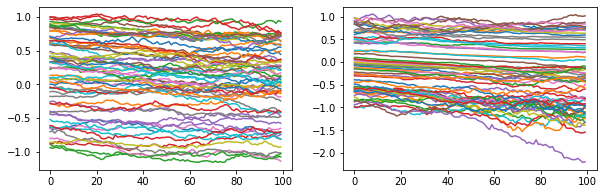

In [11]:
# test_trajectory
bs = 64 ; s_span = torch.linspace(0, 1, 100)
x0 = prior.sample(torch.Size([bs]))
traj = nsde.trajectory(x0, s_span).detach().cpu()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i in range(bs):
    ax[0].plot(traj[:,i,0])
    ax[1].plot(traj[:,i,1])

## DataControl in Drift and Diffusion

In [12]:
f = nn.Sequential(DataControl(), nn.Linear(4, 64), nn.Tanh(), nn.Linear(64, 2))
g = nn.Sequential(DataControl(), nn.Linear(4, 64), nn.Tanh(), nn.Linear(64, 2))

nsde = NeuralSDE(f, g,
                noise_type='diagonal',
                sde_type='ito',
                sensitivity='adjoint',
                s_span=torch.linspace(0, 1, 100),
                solver='euler',
                atol=0.0001,
                rtol=0.0001).to(device)

In [13]:
# test backward adjoint
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
print(x0.grad.shape)

# test backward autograd
nsde.sensitivity = 'autograd'
x0 = prior.sample(torch.Size([100])).requires_grad_(True)
y = nsde(x0)
y.sum().backward()
print(x0.grad.shape)

torch.Size([100, 2])
torch.Size([100, 2])


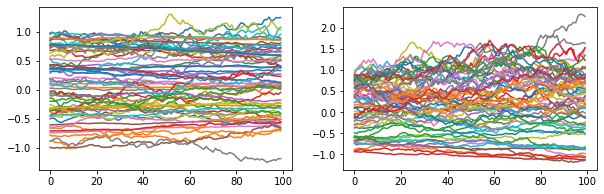

In [14]:
# test_trajectory
bs = 64 ; s_span = torch.linspace(0, 1, 100)
x0 = prior.sample(torch.Size([bs]))
traj = nsde.trajectory(x0, s_span).detach().cpu()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i in range(bs):
    ax[0].plot(traj[:,i,0])
    ax[1].plot(traj[:,i,1])